In [1]:
!pip install shapely
!pip install rtree networkx
%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Load template  
Load main image  
Iterate over main image and match template  
Iterate matching of template over all angles from 0 ,90,180,270 and create a list of best matched positions  
Load all the lines items stored in vector graphics in pdf  
for loop over line items:  
&emsp;check if line intersects with the matched template box over all angles  
&emsp;find triangles in the lines filtered intersecting with the template
&emsp;filter lines in triangles to get lines which are exclusively dimension lines
&emsp;remove dimension lines and triangles lines from line items
for loop over filtered line items:
&emsp;find interesections with triangles in the remaining which likely would be extension lines   

we should have :  
dimension_line=[]  
arrow triangles =[]  
extension lines =[]  
part_lines=[]

In [2]:
from shapely.wkt import loads as load_wkt
import json
from create_structures import *
from BOM import *

import fitz
from shapely.geometry import LineString,Polygon,Point,box
import cv2
import os
from enum import Enum

import random
import numpy as np
from itertools import combinations
import pandas as pd

doc = fitz.open("AUTHORING_APP_116e3300_rev H_drw_PROE.pdf")
page = doc[2]

DPI = 300
scale = DPI / 72

flag = None
main_image = cv2.imread("image_BAE2.png")
h, w, c = main_image.shape
graph_img = np.ones((h, w, c), dtype=np.uint8) * 255
graph_img_filename = "graph_BAE2.png"
coco_json_path = "image_BAE2_annotations.coco.json"

In [61]:
# Load the main image and template
dimension_lines, dimension_arrow_triangles, extension_lines, connecting_part_lines, part_arrow_triangles, part_item = find_components_for_BOM(doc,page,main_image,scale)

with open("dimension_line.txt", "w") as f:
    for item in dimension_lines:
        f.write(f"{item.wkt}\n")
with open("dimension_arrow_triangles.txt", "w") as f:
    for item in dimension_arrow_triangles:
        f.write(f"{item.wkt}\n")
with open("extension_lines.txt", "w") as f:
    for item in extension_lines:
        f.write(f"{item.wkt}\n")
with open("connecting_part_lines.txt", "w") as f:
    for item in connecting_part_lines:
        f.write(f"{item.wkt}\n")
with open("part_arrow_triangles.txt", "w") as f:
    for item in part_arrow_triangles:
        f.write(f"{item.wkt}\n")
with open("part_items.txt", "w") as f:
    for item in part_item:
        f.write(f"{item.wkt}\n")
    

Filtered :  34
34


In [3]:


with open("dimension_line.txt", "r") as f:
    dimension_lines = [load_wkt(line.strip()) for line in f]

with open("dimension_arrow_triangles.txt", "r") as f:
    dimension_arrow_triangles = [load_wkt(line.strip()) for line in f]

with open("extension_lines.txt", "r") as f:
    extension_lines = [load_wkt(line.strip()) for line in f]

with open("connecting_part_lines.txt", "r") as f:
    connecting_part_lines = [load_wkt(line.strip()) for line in f]
    
with open("part_arrow_triangles.txt", "r") as f:
    part_arrow_triangles = [load_wkt(line.strip()) for line in f]

with open("part_items.txt", "r") as f:
    part_item = [load_wkt(line.strip()) for line in f]

part_items=[]
for circle in part_item:
    center = circle.centroid
    x_center, y_center = center.x , center.y
    boundary_point = list(circle.exterior.coords)[0]
    radius = center.distance(Point(boundary_point))
    x, y, w, h = x_center - radius, y_center - radius, 2 * radius, 2 * radius
    text = page.get_text("text",clip=(int(x/scale),int(y/scale),int((x+w)/scale),int((y+h)/scale)))
    part_items.append([circle,radius,text])

In [4]:


with open(coco_json_path) as f:
    data = json.load(f)


for ann in data["annotations"]:
    x, y, w, h = ann["bbox"]
    cv2.putText(graph_img, f"{int(x),int(y),int(w),int(h)}", (int(x), int(y) - 20),  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.rectangle(graph_img, (int(x),int(y)),(int(x + w) , int(y + h)) , (0, 0, 255), 2)

cv2.imwrite(graph_img_filename,graph_img)


True

0. Given:  
    dimension_line=[]  
    dimension_arrow_triangles =[]  
    extension_lines =[]  
    part_lines=[]  
    part_arrow_triangles =[]  
1. Extension line intersecting with arrow polygon intersecting with a line , check alignment left or right or top or bottom DONE
2. if the y coordinate or x coordinate is common in intersections --> make that a pair DONE
3. move the part circles to the intersecting point
4. extract the centre text and record the centre coordinate DONE
5. drop the extension lines to the end and find the containing part numbers
6. Store the dimensions and part numbers in order in a data structure
   - store in DS such that the heirarchy is maintained
   - dimenions are associated with each part
8. Print the entire DS into a table
9. Handle corner cases where there is dimension mentioned in the below format
   - line extension line extension line and line with the dimension mentioned in the surrounding area 
   - extension line line extension line and text containing dimension in the surrounding area
10. If multiple drawings present in a group check for the projection format , handle the top view and side view accordingly
     

In [5]:

print(len(extension_lines))
print(len(dimension_lines))

dimension_extension_sets = []
for intersecting_dimension_line in dimension_lines:
    for intersecting_dimension_arrows in dimension_arrow_triangles:
        if intersecting_dimension_line.intersects(intersecting_dimension_arrows):
            for intersecting_extension_lines in extension_lines:
                if intersecting_dimension_arrows.intersects(intersecting_extension_lines):
                    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

                    pts = np.array(intersecting_dimension_line.coords, np.int32).reshape((-1, 1, 2))
                    cv2.polylines(graph_img, [pts], isClosed=False, color=color, thickness=12)
                    
                    pts = np.array(intersecting_extension_lines.coords, np.int32).reshape((-1, 1, 2))
                    cv2.polylines(graph_img, [pts], isClosed=False, color=color, thickness=12)
                    
                    cv2.putText(graph_img, f"{str(int(intersecting_dimension_line.coords[0][0])),str(int(intersecting_dimension_line.coords[0][1]))}", (int(intersecting_dimension_line.coords[0][0])-10, int(intersecting_dimension_line.coords[0][1]) - 10),  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                    cv2.putText(graph_img, f"{str(int(intersecting_dimension_line.coords[-1][0])),str(int(intersecting_dimension_line.coords[-1][1]))}", (int(intersecting_dimension_line.coords[-1][0])-10, int(intersecting_dimension_line.coords[-1][1]) - 10),  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                    dimension_extension_sets.append([intersecting_dimension_line,intersecting_extension_lines])

cv2.imwrite(graph_img_filename,graph_img)

#print(len(polygons))

36
32


True

In [6]:

y_groups = defaultdict(list)
x_groups = defaultdict(list)

dimensions_dict_x = []
dimensions_dict_y = []

class Pattern(Enum):
    pattern1 = ["left_arrow","dimension_line","dimension_line","right_arrow"] 
    pattern2 = ["dimension_line","right_arrow", "left_arrow","dimension_line"]
    pattern3 = ["left_arrow","dimension_line","right_arrow"]
    
    pattern4 = ["top_arrow","dimension_line","dimension_line","bottom_arrow"]
    pattern5 = ["dimension_line","bottom_arrow", "top_arrow","dimension_line"]
    pattern6 = ["bottom_arrow","dimension_line","top_arrow"]

pattern_map = {
                "pattern1": {
                    "patterns": [Pattern.pattern1.value],
                    "offsets": [(-2, -1), (0, 1)]
                },
                "pattern2": {
                    "patterns": [Pattern.pattern2.value],
                    "offsets": [(-2, -1), (0, 1)]
                },
                "pattern3": {
                    "patterns": [Pattern.pattern3.value],
                    "offsets": [(-1, 0)]
                },
                "pattern4": {
                    "patterns": [Pattern.pattern4.value],
                    "offsets": [(-2, -1), (0, 1)]
                },
                "pattern5": {
                    "patterns": [Pattern.pattern5.value],
                    "offsets": [(-2, -1), (0, 1)]
                },
                "pattern6": {
                    "patterns": [Pattern.pattern6.value],
                    "offsets": [(-1, 0)]
                }
            }

for dim in dimension_lines:
    for x,y in dim.coords:
        y_groups[(y)].append(((x), (y)))
        x_groups[(x)].append(((x), (y)))


dimensions_dict_y = find_patterns(y_groups, dimension_lines, dimension_arrow_triangles, dimensions_dict_y,pattern_map,page)
dimensions_dict_x = find_patterns(x_groups, dimension_lines, dimension_arrow_triangles, dimensions_dict_x,pattern_map,page)

dimensions_dict_y.extend(dimensions_dict_x)

for i,(item) in enumerate(dimensions_dict_y):
    print(f"{item["coords"][0],item["value"],item["pattern"]}")
    


([<LINESTRING (3285.309 7194.501, 3972.648 7194.501)>, <LINESTRING (4301.782 7194.501, 5569.561 7194.501)>], [[' tolerance:15\nL\n']], ['pattern1'])
([<LINESTRING (3285.309 6958.28, 4422.317 6958.28)>, <LINESTRING (4751.451 6958.28, 5888.459 6958.28)>], [[' tolerance:15\nK\n']], ['pattern1'])
([<LINESTRING (3285.309 6722.06, 4820.145 6722.06)>, <LINESTRING (5149.278 6722.06, 7034.128 6722.06)>], [[' tolerance:15\nJ\n']], ['pattern1'])
([<LINESTRING (3285.309 6485.839, 5154.601 6485.839)>, <LINESTRING (5483.734 6485.839, 7353.025 6485.839)>], [[' tolerance:15\nH\n']], ['pattern1'])
([<LINESTRING (3285.309 6249.619, 5556.53 6249.619)>, <LINESTRING (5885.664 6249.619, 8498.695 6249.619)>], [[' tolerance:15\nF\n']], ['pattern1'])
([<LINESTRING (3285.309 6013.398, 5886.884 6013.398)>, <LINESTRING (6216.018 6013.398, 8817.592 6013.398)>], [[' tolerance:15\nE\n']], ['pattern1'])
([<LINESTRING (3285.309 5777.178, 6331.477 5777.178)>, <LINESTRING (6660.611 5777.178, 10282.159 5777.178)>], [[' t

In [7]:

for line in dimension_lines:
    # Convert Shapely LineString to a NumPy array for OpenCV
    pts = np.array(line.coords, np.int32).reshape((-1, 1, 2))
    
    # Draw the line on the image
    cv2.polylines(graph_img, [pts], isClosed=False, color=(0, 0, 255), thickness=12)
    
for line in extension_lines:
    # Convert Shapely LineString to a NumPy array for OpenCV
    pts = np.array(line.coords, np.int32).reshape((-1, 1, 2))
    
    # Draw the line on the image
    cv2.polylines(graph_img, [pts], isClosed=False, color=(255, 0, 255), thickness=12)
    
cv2.imwrite(graph_img_filename,graph_img)


True

In [8]:

intersections=[]
def find_intersecting_pairs(circles):
    """
    Finds pairs of intersecting circles efficiently.
    
    :param circles: List of Shapely Polygons (circles as buffered Points)
    :return: List of intersecting circle pairs
    """
    intersecting_pairs = []

    # Precompute centroid and radius for each circle
    circle_data = [
        (circle_item.centroid.x, circle_item.centroid.y, radius)
        for circle_item,radius,text in circles
    ]
    
    for (x,y, radius1), (x2,y2, radius2) in combinations(circle_data, 2):
       # print(radius1,radius2)
        buffered1 = Point(x, y).buffer(radius1+10)
        buffered2 = Point(x2, y2).buffer(radius2)
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        
        if buffered1.intersects(buffered2):  # Check intersection
           # print("intersects")
            intersecting_pairs.append((buffered1, buffered2))
            cv2.circle(graph_img, (int(x), int(y)), int(radius1), color, 22)
            cv2.circle(graph_img, (int(x2), int(y2)), int(radius2), color, 22)
       
    return intersecting_pairs

# Find intersecting pairs

intersections = find_intersecting_pairs(part_items)
print(len(intersections))
cv2.imwrite(graph_img_filename,graph_img)


6


True

1. find circle connecting to connecting part line which is connecting to arrow triangle, record this set
2. replace the centroid of triangle with the circle along with intersecting circles or any other polygons.
3. iteratively check for intersecting parts and move them together
   

In [9]:
#part_item connecting_part_lines part_arrow_triangles
part_groups = defaultdict(list)
circle_groups= []
part_arrows= defaultdict(list)

for circle_item,radius,text in part_items:
    for connecting_line in connecting_part_lines:
        if Point(circle_item.centroid.x, circle_item.centroid.y).buffer(radius).intersects(connecting_line.buffer(10)):
            for arrow in part_arrow_triangles:
                if connecting_line.intersects(arrow.buffer(10)):
                    part_arrows[(arrow.centroid.x), (arrow.centroid.y)].append(arrow)
                    part_groups[(arrow.centroid.x), (arrow.centroid.y)].append(Part(arrow.centroid ,text.split('\n')[0],text.split('\n')[1]))
                    inter_circle = [(other_circle,other_radius,other_text.strip()) for other_circle,other_radius,other_text in part_items if (text.replace('\n', '/') != other_text.replace('\n', '/') and circle_item != other_circle) and circle_item.buffer(radius+10).intersects(other_circle.buffer(other_radius))]

                    if inter_circle != []:
                        for c,r,t in inter_circle:
                            part_groups[(arrow.centroid.x), (arrow.centroid.y)].append(Part(arrow.centroid ,t.split('\n')[0],t.split('\n')[1]))

                    cv2.circle(graph_img, (int(arrow.centroid.x), int(arrow.centroid.y)), int(radius), (0,0,255), 22)
                    circle_groups.append([int(arrow.centroid.x), int(arrow.centroid.y),radius])

print(len(part_groups))
cv2.imwrite(graph_img_filename,graph_img)


22


True

Constructing class objects  
Given:  
dimensions_dict : line coordinates, dimension values associated, pattern enum  
part_groups : part coordinates with line numbers and qty  
annotations : bounding box  

pattern1 = ["left_arrow","dimension_line","text","dimension_line","right_arrow"]
pattern2 = ["dimension_line","right_arrow", "left_arrow","dimension_line"]
pattern3 = ["left_arrow","dimension_line","right_arrow"]

pattern4 = ["top_arrow","dimension_line","text","dimension_line","bottom_arrow"]
pattern5 = ["dimension_line","bottom_arrow", "top_arrow","dimension_line"]
pattern6 = ["bottom_arrow","dimension_line","top_arrow"]

if pattern == 1 or 2 or 3 :  
    horizonal dimension lines = create boundin box from the min x to max x , 0 :h  
if pattern == 4 or 5 or 6 :  
    vertical dimension lines = create boundin box from the min y to max y , 0 :w  
    
find part number points within the bounding box   

create new BOM object   
    1. add dimension lines : coordinates, dimensions extracted from table  
    2. add part numbers : coordinates, line item and qty  
    3. pattern enum  

create a tree for traversal using dfs , insert nodes based on heirarchy of dimensions , identifying the parent and its child nodes

    


In [10]:
with open(coco_json_path) as f:
    data = json.load(f)
    
flat_parts = [part for parts in part_groups.values() for part in parts]

for ann in data["annotations"]:
    if ann["category_id"]==2:
        x , y, w, h = ann["bbox"]
        table_bbox = x/scale, y/scale, (x + w)/scale, (y + h)/scale
        clip = fitz.Rect(x/scale, y/scale, (x + w)/scale, (y + h)/scale)
        
        tables = page.find_tables(clip=clip)
        for table in tables.tables:
            first_table = table
    
            # Extract as list of rows
            data = first_table.extract()

            # Create DataFrame
            df = pd.DataFrame(data[2:], columns=data[1])
            
            if 'DIMENSION' in df.columns:
                dim_dataframe = df
                print(dim_dataframe)
                break
            else:
                continue

  DIMENSION  G10  G11
0         D  520  610
1         E  458  548
2         F  445  535
3         H  396  486
4         J  383  473
5         K  334  424
6         L  321  411


In [11]:
def extract_tables_from_drawingbox(data, drawing_bbox):
    minx, miny, maxx, maxy = drawing_bbox
    sub_box = box(minx, miny, maxx, maxy)
    
    for ann in data["annotations"]:
        if ann["category_id"]==2:
            
            x , y, w, h = ann["bbox"]
            table_bbox = box(x, y, (x + w), (y + h))
            if sub_box.intersects(table_bbox):
                #print("herer")
                clip = fitz.Rect(x/scale, y/scale, (x + w)/scale, (y + h)/scale)
                
                tables = page.find_tables(clip=clip)
               # print("no of table",len(tables.tables))
                for table in tables.tables:
                    # Extract as list of rows
                    first_table=table
                    data = first_table.extract()
                  #  print(data)
                    # Create DataFrame
                    df = pd.DataFrame(data[2:], columns=data[1])
                 #   print("Dataframe :",df)
                    if 'DIMENSION' in df.columns:
                        dim_dataframe = df
                        return dim_dataframe
                    else:
                        continue
                    

In [20]:

with open(coco_json_path) as f:
    data = json.load(f)
    
flat_parts = [part for parts in part_groups.values() for part in parts]
group ='G10'
dim_dataframe = None


for ann in data["annotations"]:              
    if ann["category_id"]==1:
        parts_in_drawing=[] 
        bom_nodes_y =[]
        diff=[]
        x , y, w, h = ann["bbox"]
        drawing_bbox = x, y, x + w, y + h
        dim_dataframe = extract_tables_from_drawingbox(data, drawing_bbox)
        print("Annotated box :", drawing_bbox)
        
        for p in flat_parts:
            if is_point_in_bbox(p.coords, drawing_bbox):
                #print(p.line,p.quantity)
                parts_in_drawing.append(p)

        print(len(parts_in_drawing))
       # print(dim_dataframe)
        bom_nodes_y, diff = construct_bom_nodes(dimensions_dict_y, parts_in_drawing, part_arrows, drawing_bbox, graph_img,page,dim_dataframe,group)

        bom_tree_y = build_bom_tree(bom_nodes_y)
        diff_tree_y = build_bom_tree(diff)
        
        for root in bom_tree_y:
            print_bom_tree(root)

        for root in diff_tree_y:
            print_bom_tree(root)

cv2.imwrite(graph_img_filename,graph_img)


Annotated box : (1970, 5557, 12269.17, 9764.220000000001)
13


  Dimensions:
    - Value: 520
  Parts:
    - Line: 2, Qty: 1
    - Line: 7, Qty: 2
    - Line: 5, Qty: AR
    - Line: 3, Qty: AR


      Parent: 520
      Dimensions:
        - Value: 458


          Parent: 458
          Dimensions:
            - Value: 445
          Parts:
            - Line: 2, Qty: 1
            - Line: 7, Qty: 2


              Parent: 445
              Dimensions:
                - Value: 396


                  Parent: 396
                  Dimensions:
                    - Value: 383
                  Parts:
                    - Line: 2, Qty: 1
                    - Line: 7, Qty: 2


                      Parent: 383
                      Dimensions:
                        - Value: 334


                          Parent: 334
                          Dimensions:
                            - Value: 321
                          Parts:
                            - Line: 4, Qty: 8


  Dimensions:


True

1. Add the part numbers in the surrounding region to the nearest dimension line, if there are multiple dim lines, then add parent node to the largest or combined dimension lines.
2. Find the dimension values from the nearest text blocks DONE
4. Extract dimension values from the tables in the drawing box region
5. GMM on the part number centroids to mask them from being overlapped from horizontal and vertical dimension lines, if they occur in same drawing DONE
6. update the pattern1 text to point to the nearest centroid in the text blocks extracted DONE
7. Dimension value lookup to write the value and tolerances DONE
   

Annotated box : (1970, 5557, 12269.17, 9764.220000000001)
Annotated box : (5024, 778, 12684.630000000001, 5498.32)
Annotated box : (2769, 554, 5050.05, 5366.61)
Annotated box : (593, 936, 2702.64, 5366.24)


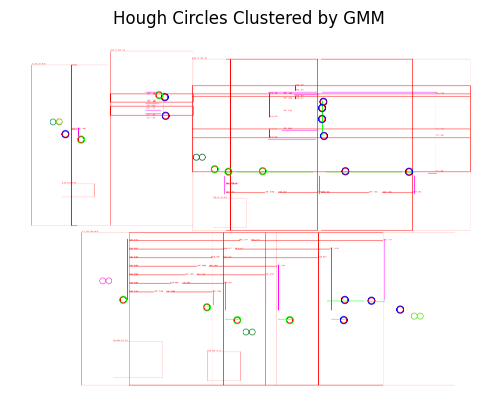

In [70]:
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


for ann in data["annotations"]:
    if ann["category_id"]==1:
        parts_in_drawing=[] 
        drawing_bbox = ann["bbox"]
        x , y, w, h = drawing_bbox
        drawing_bbox = x, y, x + w, y + h
        
        print("Annotated box :",drawing_bbox)
        
        features = np.array([[x1] for (x1,y1,radius) in circle_groups if x <= x1 <= x+w and y <= y1 <= y+h])
        clusters = np.array([[x1,y1] for (x1,y1,radius) in circle_groups if x <= x1 <= x+w and y <= y1 <= y+h])
        n_components = 2  # You can tune this
        gmm = GaussianMixture(n_components=n_components, covariance_type='spherical', random_state=42)
        labels = gmm.fit_predict(features)
        #output_img = cv2.cvtColor(graph_img, cv2.COLOR_GRAY2BGR)
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255,255,0)]
        
        for (label, (x,y)) in zip(labels, clusters):
            cv2.circle(graph_img, (int(x), int(y)), int(100), colors[label % len(colors)], 22)
        
# Show output
plt.imshow(cv2.cvtColor(graph_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Hough Circles Clustered by GMM")
plt.show()



Annotated box : (1970, 5557, 12269.17, 9764.220000000001)
8
[0.99995626 0.0093535 ]
[-0.0093535   0.99995626]


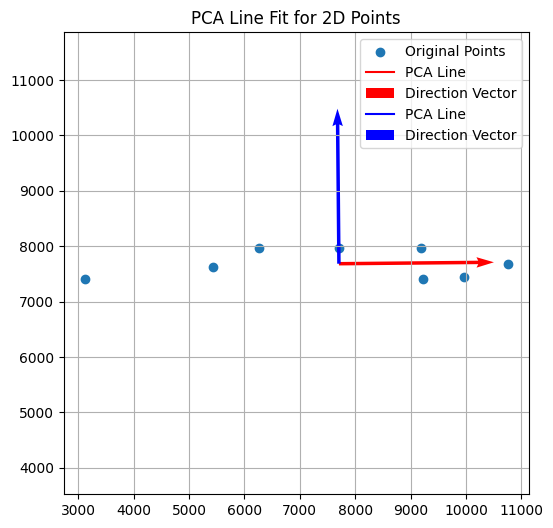

Annotated box : (5024, 778, 12684.630000000001, 5498.32)
9
[ 0.98803825 -0.15420897]
[0.15420897 0.98803825]


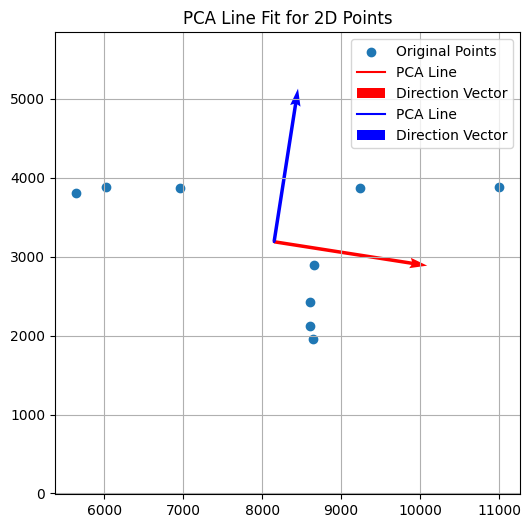

Annotated box : (2769, 554, 5050.05, 5366.61)
3
[0.21448066 0.97672824]
[ 0.97672824 -0.21448066]


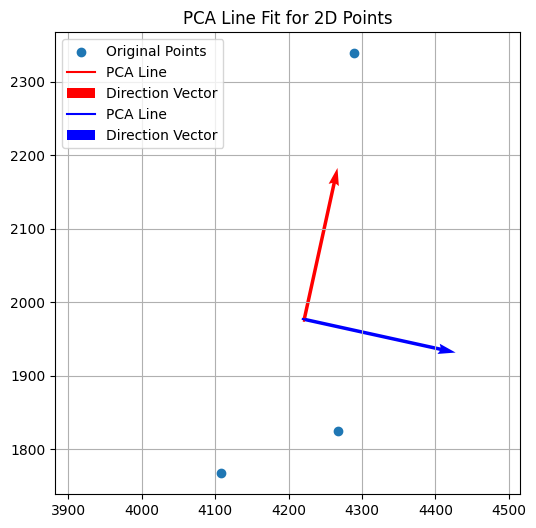

Annotated box : (593, 936, 2702.64, 5366.24)
2
[0.94467366 0.32801169]
[-0.32801169  0.94467366]


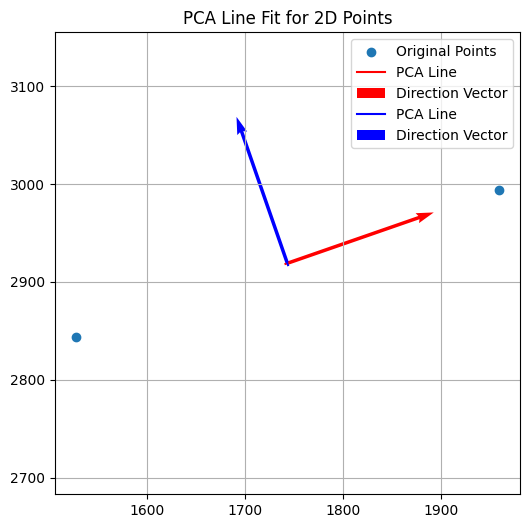

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

for ann in data["annotations"]:
    if ann["category_id"]==1:
        parts_in_drawing=[] 
        drawing_bbox = ann["bbox"]
        x , y, w, h = drawing_bbox
        drawing_bbox = x, y, x + w, y + h
        
        print("Annotated box :",drawing_bbox)
        clusters = np.array([[x1,y1] for (x1,y1,radius) in circle_groups if x <= x1 <= x+w and y <= y1 <= y+h])
        print(len(clusters))
        pca = PCA(n_components=2)
        pca.fit(clusters)
        
        # Extract mean and principal components
        mean = pca.mean_
        direction = pca.components_[0]  # First principal component (line direction)
        print(direction)
        direction_2 = pca.components_[1]
        print(direction_2)
        # Create line along the principal component
        t = np.linspace(-2, 2, 100)
        line = mean + t[:, None] * direction  # Parametric form of the line
        line_2 = mean + t[:, None] * direction_2 

        # Plot original points and PCA line
        plt.figure(figsize=(6, 6))
        plt.scatter(clusters[:, 0], clusters[:, 1], label='Original Points')
        plt.plot(line[:, 0], line[:, 1], color='red', label='PCA Line')
        plt.quiver(*mean, *direction, scale=3, color='red', angles='xy', label='Direction Vector')

        plt.plot(line_2[:, 0], line_2[:, 1], color='blue', label='PCA Line')
        plt.quiver(*mean, *direction_2, scale=3, color='blue', angles='xy', label='Direction Vector')
        
        plt.axis('equal')
        plt.grid(True)
        plt.legend()
        plt.title('PCA Line Fit for 2D Points')
        plt.show()

In [212]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS

from sklearn.decomposition import PCA


for ann in data["annotations"]:
    if ann["category_id"]==1:
        parts_in_drawing=[] 
        drawing_bbox = ann["bbox"]
        x , y, w, h = drawing_bbox
        drawing_bbox = x, y, x + w, y + h
        
        print("Annotated box :",drawing_bbox)
        
        features = np.array([[x1,y1] for (x1,y1,radius) in circle_groups if x <= x1 <= x+w and y <= y1 <= y+h])
        eps = 150  # max y-difference to consider aligned

        # Only use y-coordinate for clustering (reshape to 2D)
      #  X_reduced = PCA(n_components=2).fit_transform(features)
        horizontal_labels = DBSCAN(eps=eps, min_samples=2,metric='euclidean').fit_predict(features[:,0].reshape(-1,1))

        # Group horizontal alignments
        horizontals = {}
        
        for i, label in enumerate(horizontal_labels):
            print(label)
            if label == -1:
                cv2.circle(graph_img, (int(features[i][0]), int(features[i][1])), int(150), (255,0,0), 42)
            elif label == 1:
                cv2.circle(graph_img, (int(features[i][0]), int(features[i][1])), int(150), (0,0,255), 42)
            elif label==0:
                cv2.circle(graph_img, (int(features[i][0]), int(features[i][1])), int(150), (0,255,0), 42)
                
            horizontals.setdefault(label, []).append(tuple(features[i]))
            print("Horizontally aligned groups:")
           # for group in horizontals.values():
             #   print(group)
                
cv2.imwrite(graph_img_filename,graph_img)



Annotated box : (1970, 5557, 12269.17, 9764.220000000001)
-1
Horizontally aligned groups:
-1
Horizontally aligned groups:
-1
Horizontally aligned groups:
0
Horizontally aligned groups:
-1
Horizontally aligned groups:
-1
Horizontally aligned groups:
0
Horizontally aligned groups:
-1
Horizontally aligned groups:
Annotated box : (5024, 778, 12684.630000000001, 5498.32)
-1
Horizontally aligned groups:
0
Horizontally aligned groups:
-1
Horizontally aligned groups:
0
Horizontally aligned groups:
-1
Horizontally aligned groups:
-1
Horizontally aligned groups:
0
Horizontally aligned groups:
0
Horizontally aligned groups:
-1
Horizontally aligned groups:
Annotated box : (2769, 554, 5050.05, 5366.61)
0
Horizontally aligned groups:
0
Horizontally aligned groups:
-1
Horizontally aligned groups:
Annotated box : (593, 936, 2702.64, 5366.24)
-1
Horizontally aligned groups:
-1
Horizontally aligned groups:


True